In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import ttest_ind,pearsonr, kendalltau, spearmanr
from helper_files import checkLinearFit, test_correlation, sensitivity_on_bin

# Inputs

external_csv = r"/home/andris/GitHub/data/school_ext_data.csv"
internal_csv = r"/home/andris/GitHub/data/school_clk_data.csv"


In [5]:
# ------------------------------------------------------
# JOIN EXTERNAL DATA WITH CLICKSTREAM DATA
# ------------------------------------------------------

# Read external data (indices and exam results)
df_ext = pd.read_csv(external_csv)

# Read internal data (clickstream data)
df_int = pd.read_csv(internal_csv)

# Combine the 2 dataframes
df_ext['URN'] = df_ext['URN'].astype('str') 
df = df_ext.set_index('URN').join(df_int.set_index('school_id'))

# ------------------------------------------------------
# ADDING NEW FEATURES AND INDICES
# ------------------------------------------------------

# Computing improvement in exam scores

qu = ['Biology','Mathematics','Chemistry','Physics']

for item in qu:
    df['exam_improv_2013-2014_' + item] = (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2014_'+item] - df['exam_score|2013_'+item]).mean()

for item in qu:
    df['exam_improv_2013-2016_' + item] = (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]) - (df['exam_score|2016_'+item] - df['exam_score|2013_'+item]).mean()

# Student activity
df['std_q_cor'] =  (df.filter(regex='_cor_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_q_all'] =  (df.filter(regex='_cor_std|q_lvl_[0-6]_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_q_ratio'] =  ((df.filter(regex='_cor_std').sum(axis=1)/(df.filter(regex='q_lvl_[0-6]_std|_cor_std').sum(axis=1)))/df['Entries|2016_Physics']).fillna(0)
df['std_q_ratio_edit'] =  ((df.filter(regex='_cor_std').sum(axis=1)/(df.filter(regex='q_lvl_[0-6]_std|_cor_std').sum(axis=1)))).fillna(0)
df['std_other'] =  (df.filter(regex='view_concept_std|play_video_std').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['std_ratio'] =  (df['user_id_std']/df['Entries|2016_Physics']).fillna(0)

# Teacher activity
df['tch_q_cor'] =  (df.filter(regex='_cor_tch').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['tch_q_all'] =  (df.filter(regex='_cor_tch|q_lvl_[0-6]_tch').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)
df['tch_q_ratio'] =  (df.filter(regex='_cor_tch').sum(axis=1)/(df.filter(regex='q_lvl_[0-6]_tch').sum(axis=1))/df['Entries|2016_Physics']).fillna(0)
df['tch_ratio'] =  (df['user_id_tch']/df['Entries|2016_Physics']).fillna(0)
df['tch_other'] = (df.filter(regex='view_assig_prog|create_group|add_assig|ad_custom_assig').sum(axis=1)/df['Entries|2016_Physics']).fillna(0)

# ------------------------------------------------------
# CLEANING THE DATA
# ------------------------------------------------------

# Remove unneeded clickstream data
df = df.drop(df.filter(regex='_tch|_std').columns,axis=1)
df = df.drop(['view_assig_prog','add_custom_assig','add_assig','create_group','add_user'],axis=1)

#  All clickstream data that is not defined is set to 0
df = df.fillna(0)

# Set all external indices with no value as NULL
df['IDACI'] = df['IDACI'].replace(to_replace=0,value=np.nan)
df['L_M_index'] = df['L_M_index'].replace(to_replace=0,value=np.nan)
df['Effectiveness'] = df['Effectiveness'].replace(to_replace=0,value=np.nan)
df['Teach_quality'] = df['Teach_quality'].replace(to_replace=0,value=np.nan)

# Select the schools that have provide all science courses in all years
df = df[(df.filter(regex='Entries') > 0).all(axis=1)]

# Remove any unecessary features
df = df.drop(df.filter(regex='Entries|exam_score'),axis=1)

df.head(5)


,IDACI,Effectiveness,Teach_quality,L_M_index,PercentageFSM,exam_improv_2013-2014_Biology,exam_improv_2013-2014_Mathematics,exam_improv_2013-2014_Chemistry,exam_improv_2013-2014_Physics,exam_improv_2013-2016_Biology,...,std_q_all,std_q_ratio,std_q_ratio_edit,std_other,std_ratio,tch_q_cor,tch_q_all,tch_q_ratio,tch_ratio,tch_other
URN,,,,,,,,,,,,,,,,,,,,,
100001,NaN,NaN,NaN,NaN,0.0,0.036272,-0.003697,-0.061495,-0.099692,0.029736,...,30.550000,0.026678,0.533552,3.350000,0.200000,0.000000,0.050000,0.000000,0.050000,0.000000
100003,NaN,NaN,NaN,NaN,0.0,-0.080350,-0.020661,-0.019674,0.052747,-0.020112,...,147.677419,0.015897,0.492792,7.193548,0.548387,1.451613,3.516129,0.022681,0.096774,1.322581
100054,5.0,1.0,1.0,1.0,19.7,0.138762,-0.006687,0.016362,0.015041,-0.035131,...,53.948718,0.008226,0.320817,11.871795,0.435897,0.102564,0.333333,0.011396,0.051282,0.358974
100065,NaN,NaN,NaN,NaN,0.0,0.096233,0.001924,0.015242,0.059983,0.064762,...,201.628571,0.010219,0.357659,15.028571,1.057143,4.114286,11.600000,0.015703,0.142857,2.028571
100076,NaN,NaN,NaN,NaN,0.0,-0.107807,0.032783,-0.044749,-0.167057,-0.109535,...,3.500000,0.034985,0.489796,0.142857,0.071429,9.571429,30.000000,0.033467,0.071429,0.000000


In [6]:
df.corr(method='kendall').filter(regex='exam_improv_2013-2016')

,exam_improv_2013-2016_Biology,exam_improv_2013-2016_Mathematics,exam_improv_2013-2016_Chemistry,exam_improv_2013-2016_Physics
IDACI,-0.034321,0.018333,-0.035060,0.013157
Effectiveness,-0.024339,-0.023375,-0.008538,-0.019949
Teach_quality,-0.003330,-0.012089,0.023980,-0.008040
L_M_index,-0.025297,-0.044488,-0.024542,-0.016013
PercentageFSM,-0.010557,0.021541,-0.013631,0.014398
exam_improv_2013-2014_Biology,0.339313,0.091186,0.139239,0.072449
exam_improv_2013-2014_Mathematics,0.079850,0.304690,0.104473,0.084608
exam_improv_2013-2014_Chemistry,0.115904,0.106338,0.294258,0.095709
exam_improv_2013-2014_Physics,0.075647,0.103871,0.122037,0.310017
exam_improv_2013-2016_Biology,1.000000,0.188189,0.293058,0.165073


In [7]:
# Some of the clickstream features look like potentally good predictors (let's test their p value)

print(test_correlation(df, df.filter(regex='std_|tch_').columns, df.filter(regex='exam_improv').columns, kendalltau).sort_values('P Value'))

                   x                                  y  Correlation   P Value
21       std_q_ratio  exam_improv_2013-2016_Mathematics     0.062271  0.008913
23       std_q_ratio      exam_improv_2013-2016_Physics     0.061632  0.009644
30  std_q_ratio_edit    exam_improv_2013-2016_Chemistry     0.056142  0.018388
29  std_q_ratio_edit  exam_improv_2013-2016_Mathematics     0.054645  0.021736
46         std_ratio    exam_improv_2013-2016_Chemistry     0.054560  0.021797
47         std_ratio      exam_improv_2013-2016_Physics     0.054334  0.022352
28  std_q_ratio_edit      exam_improv_2013-2016_Biology     0.053464  0.024751
22       std_q_ratio    exam_improv_2013-2016_Chemistry     0.052178  0.028425
31  std_q_ratio_edit      exam_improv_2013-2016_Physics     0.045800  0.054439
7          std_q_cor      exam_improv_2013-2016_Physics     0.043483  0.067841
15         std_q_all      exam_improv_2013-2016_Physics     0.043441  0.067891
6          std_q_cor    exam_improv_2013-2016_Chemis

,Coef,R^2,X,Y,intercept
0,-0.242350,0.003095,std_q_ratio,exam_improv_2013-2014_Biology,0.005142
12,-0.003215,0.000143,std_ratio,exam_improv_2013-2016_Biology,-0.003286
11,-0.002647,0.000072,std_ratio,exam_improv_2013-2014_Physics,-0.010224
16,-0.002548,0.000038,std_q_ratio_edit,exam_improv_2013-2014_Biology,0.002518
9,-0.001257,0.000033,std_ratio,exam_improv_2013-2014_Mathematics,0.003563
8,-0.000759,0.000010,std_ratio,exam_improv_2013-2014_Biology,0.002177
10,0.000690,0.000008,std_ratio,exam_improv_2013-2014_Chemistry,-0.001261
19,0.002734,0.000027,std_q_ratio_edit,exam_improv_2013-2014_Physics,-0.011212
13,0.007709,0.001119,std_ratio,exam_improv_2013-2016_Mathematics,-0.022725
17,0.009703,0.000693,std_q_ratio_edit,exam_improv_2013-2014_Mathematics,0.001520


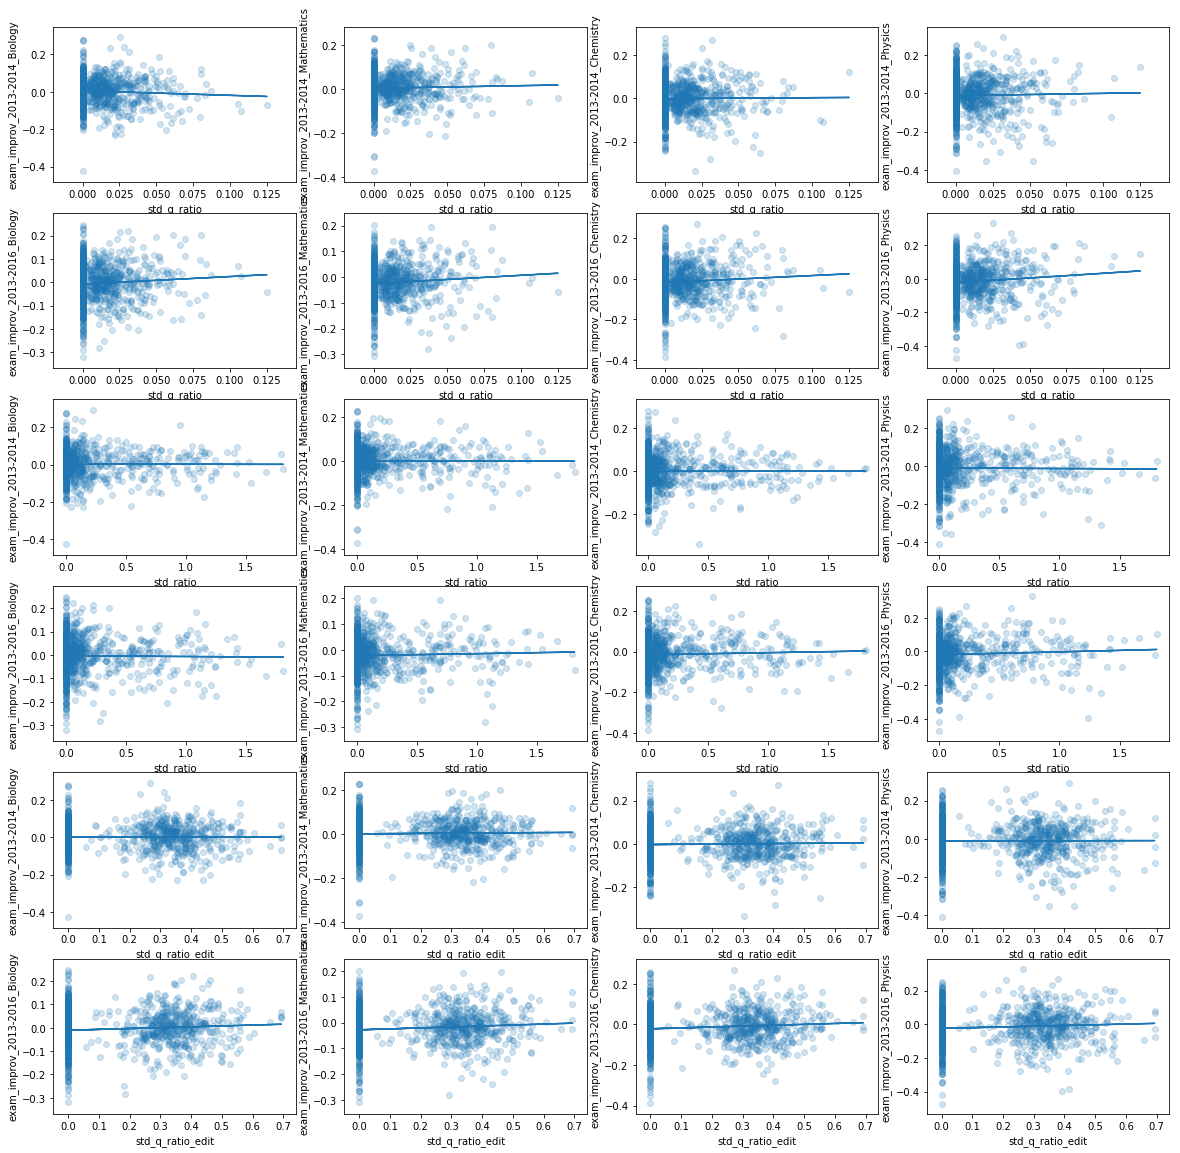

In [8]:
# std_q_ratio and std_ratio seem to be the most promising, let's plot them and see how they look like

checkLinearFit(df,['std_q_ratio','std_ratio','std_q_ratio_edit'],df.filter(regex='exam_improv').columns,n_rows=6, n_cols=4,figsize=(20,20),log=['yes','yes']).sort_values(by='Coef')

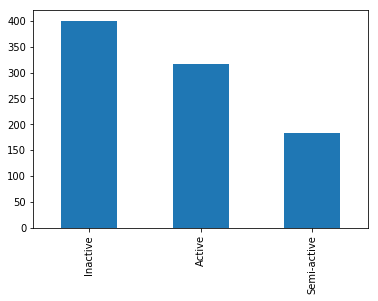

In [9]:
# Both look promising, let's try identifing subgroups

# Bin the schools into seperate categories

def bin_groups(df, feature, bins, group_names):
    
    categories = pd.cut(df[feature],bins, labels=group_names)
    return categories


# ------------------------------------------------------
# Choose a feature and determine distribution
# ------------------------------------------------------

bins = [-0.1, 0, 0.1,10000]
group_names = ['Inactive','Semi-active','Active']

df['categories'] = bin_groups(df,'std_ratio',bins,group_names)

# Plot a histogram
df['categories'].value_counts().plot(kind='bar')



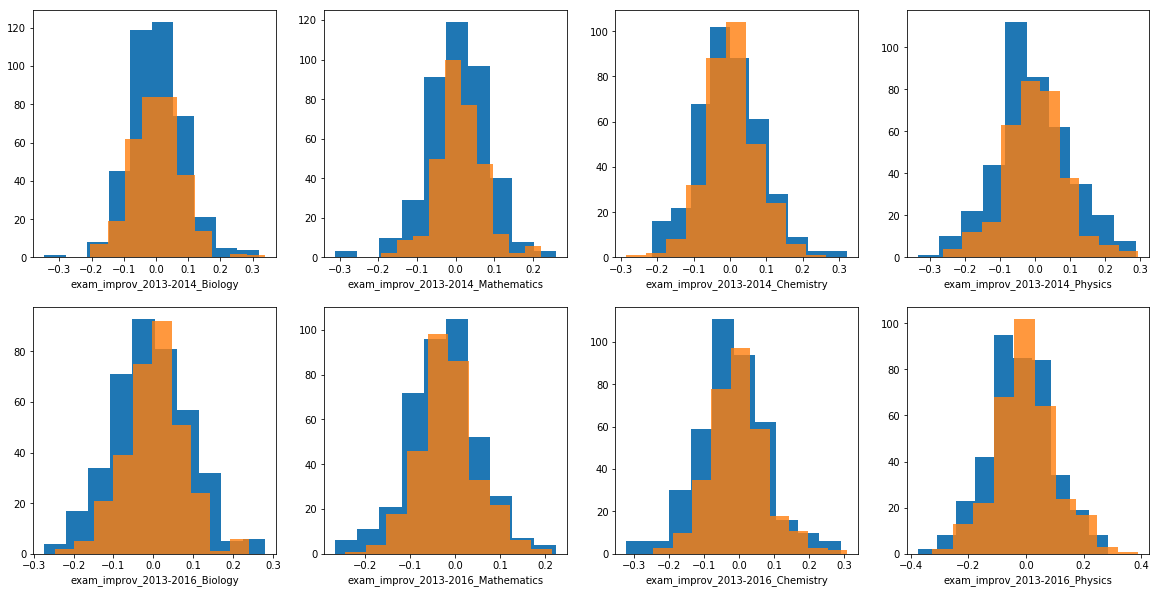

In [10]:
def plotHistograms(feature_list,nrows, ncols, figsize=(20,10)):
    
    
    plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize);

    count = 1;
    for feature in feature_list:
        
        plt.subplot(nrows,ncols,count)
        plt.hist(df[df['categories']=='Inactive'][feature])
        plt.hist(df[df['categories']=='Active'][feature],alpha=0.8)
        plt.xlabel(feature)
        count += 1
    
plotHistograms(df.filter(regex='exam_improv').columns,2,4)

In [12]:
# Doing an F-test on all variables of interest

from sklearn.feature_selection import f_classif

df_test = df[df['categories']!= 'Semi-active']

X = df_test.filter(regex='exam_improv')
y = [1 if item == 'Active' else 0 for item in df_test['categories']]
F, pval = f_classif(X, y)

df_score = pd.DataFrame({'Key':X.keys(),'F score':F,'p values':pval})

df_score.sort_values('p values')

,F score,Key,p values
7,5.397046,exam_improv_2013-2016_Physics,0.020451
6,4.934415,exam_improv_2013-2016_Chemistry,0.026640
5,3.866692,exam_improv_2013-2016_Mathematics,0.049640
4,1.917056,exam_improv_2013-2016_Biology,0.166614
1,1.354593,exam_improv_2013-2014_Mathematics,0.244866
3,1.333153,exam_improv_2013-2014_Physics,0.248631
2,0.464922,exam_improv_2013-2014_Chemistry,0.495554
0,0.017323,exam_improv_2013-2014_Biology,0.895325


In [13]:
# Looks good, do a sensitivity test to check what value of the cut-off needs investigating
bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,200))*0.01
df_score = sensitivity_on_bin(df, 'std_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], cut_off_array)

df_score.head(5)

,Cut off,F score,Group_2 - Group_0,Key,Num active,p values
exam_improv_2013-2014_Biology,0.01,0.010987,0.000546,exam_improv_2013-2014_Biology,497,0.916544
exam_improv_2013-2014_Mathematics,0.01,0.612308,0.003607,exam_improv_2013-2014_Mathematics,497,0.434127
exam_improv_2013-2014_Chemistry,0.01,0.286215,0.002832,exam_improv_2013-2014_Chemistry,497,0.592789
exam_improv_2013-2014_Physics,0.01,0.100786,0.002058,exam_improv_2013-2014_Physics,497,0.750962
exam_improv_2013-2016_Biology,0.01,3.510098,0.010527,exam_improv_2013-2016_Biology,497,0.061322


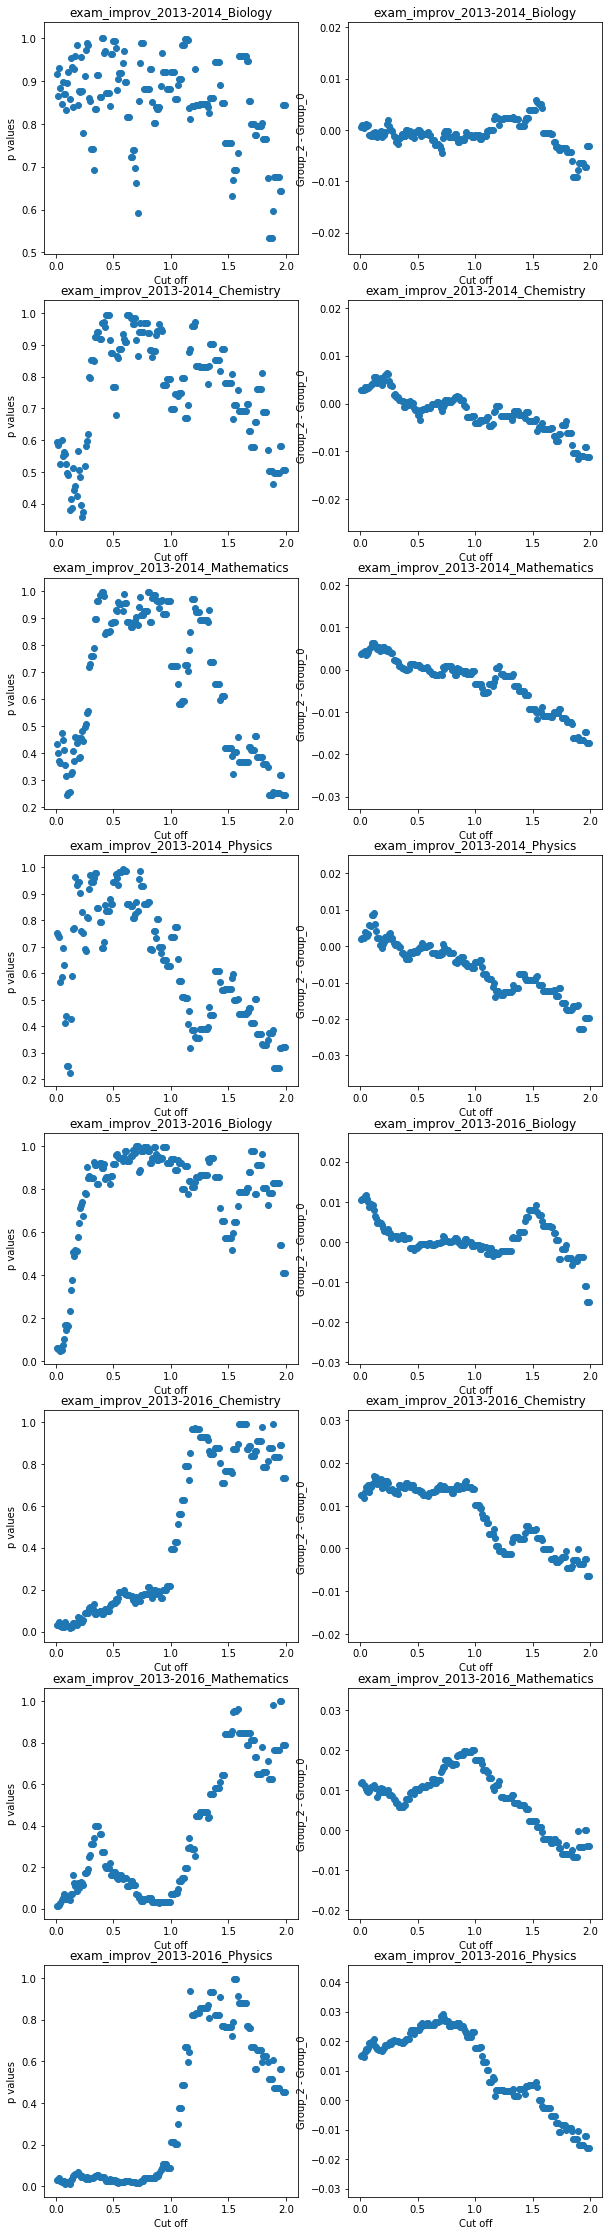

In [15]:

x_range = np.unique(df_score['Key'])
y_range = ['p values','Group_2 - Group_0']

n_rows = len(x_range)
n_cols = len(y_range)
plt.subplots(n_rows,n_cols, figsize=(10,40))
        

count = 1
for item_x in x_range:
    
    df_test = df_score[df_score['Key'] == item_x]
    for item_y in y_range:

        plt.subplot(n_rows,n_cols,count)
        plt.scatter(df_test['Cut off'],df_test[item_y])
        #plt.plot(df_test['Cut off'], np.ones(len(df_test['Cut off']))*0.05)
        plt.xlabel('Cut off')
        plt.ylabel(item_y)
        plt.title(item_x)
        
        count += 1

In [16]:
# Looks good, do a sensitivity test to check what value of the cut-off needs investigating
bins = [-0.1, 0, 1, 1000]
cut_off_array = np.array(range(1,350))*0.0001
df_score = sensitivity_on_bin(df, 'std_q_ratio', df.filter(regex='exam_improv').columns, bins, ['Inactive','Semi-active','Active'], cut_off_array)

df_score.head(5)

,Cut off,F score,Group_2 - Group_0,Key,Num active,p values
exam_improv_2013-2014_Biology,0.0001,0.003381,0.000302,exam_improv_2013-2014_Biology,489,0.953643
exam_improv_2013-2014_Mathematics,0.0001,0.739237,0.003946,exam_improv_2013-2014_Mathematics,489,0.390135
exam_improv_2013-2014_Chemistry,0.0001,0.550575,0.003912,exam_improv_2013-2014_Chemistry,489,0.458277
exam_improv_2013-2014_Physics,0.0001,0.263309,0.003313,exam_improv_2013-2014_Physics,489,0.607982
exam_improv_2013-2016_Biology,0.0001,2.606937,0.009043,exam_improv_2013-2016_Biology,489,0.106749


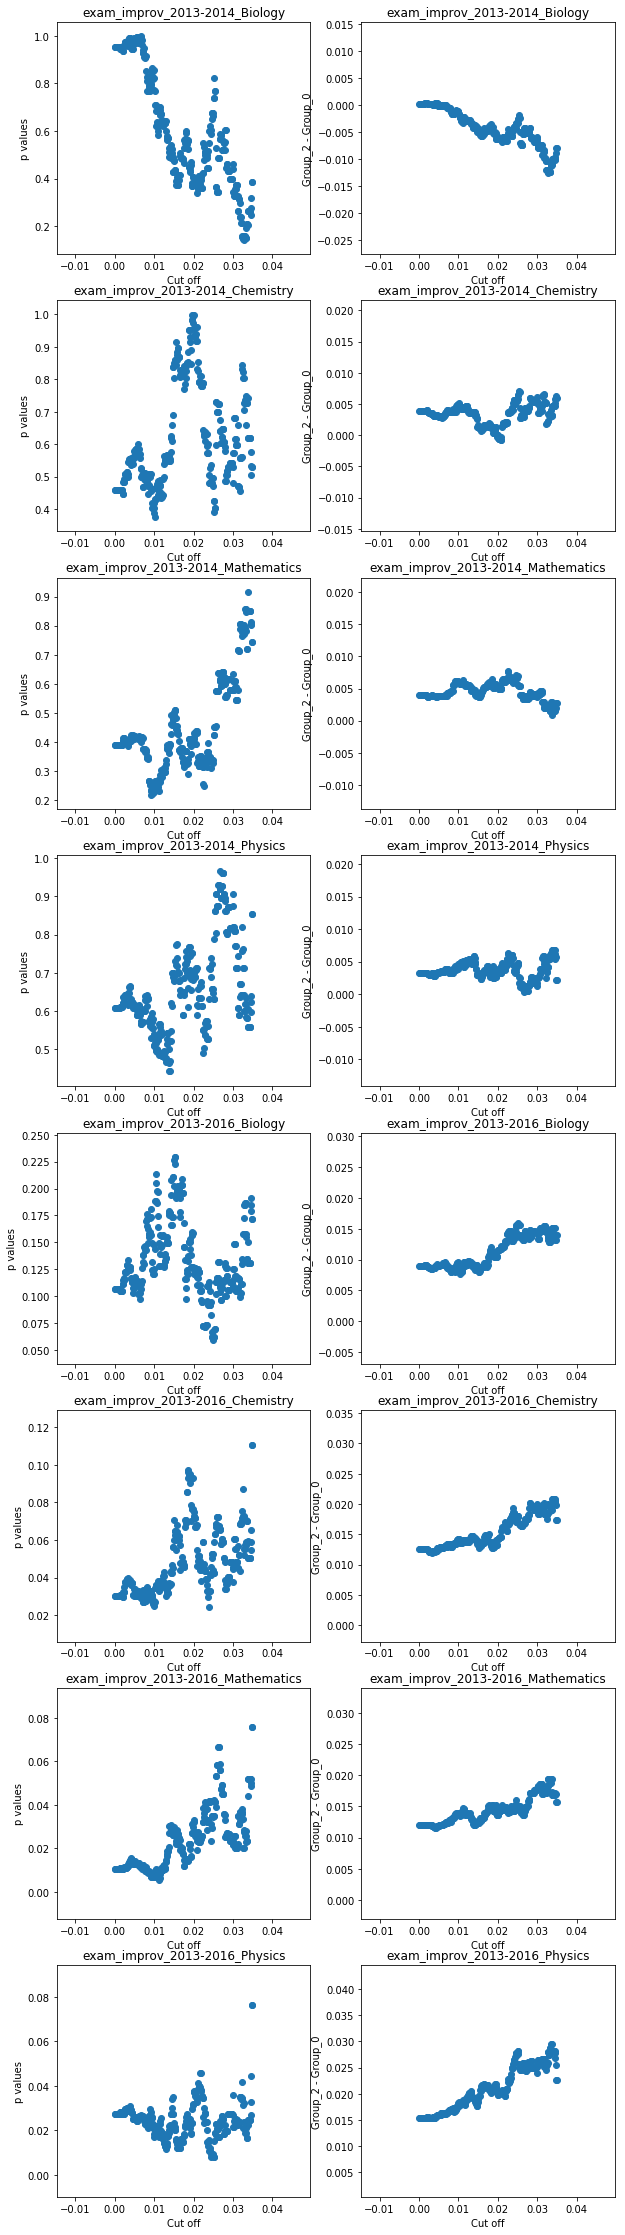

In [17]:

x_range = np.unique(df_score['Key'])
y_range = ['p values','Group_2 - Group_0']

n_rows = len(x_range)
n_cols = len(y_range)
plt.subplots(n_rows,n_cols, figsize=(10,40))
        

count = 1
for item_x in x_range:
    
    df_test = df_score[df_score['Key'] == item_x]
    for item_y in y_range:

        plt.subplot(n_rows,n_cols,count)
        plt.scatter(df_test['Cut off'],df_test[item_y])
        #plt.plot(df_test['Cut off'], np.ones(len(df_test['Cut off']))*0.05)
        plt.xlabel('Cut off')
        plt.ylabel(item_y)
        plt.title(item_x)
        
        count += 1